In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [26]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.3
testing_time = 3

max_x = 2
max_v = 2
n_train = 2
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_SHM_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[0.18827623 0.66066734]
[-0.00123644 -1.1306564 ]


In [27]:

moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-5
invar_density = 40
invar_range = 3
known_kernel = get_invariance_kernel(DampedSHMInvariance, invar_range, invar_density, jitter) #switch
known = get_GPR_model(known_kernel, SHMEpsilonMean(known_kernel), data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
poly_f_d = 2
poly_g_d = 2
learnt_kernel = get_parameterised_invariance_kernel(DampedPolynomialInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model = get_GPR_model(learnt_kernel, PolynomialEpsilonMean(learnt_kernel), data, 3000)
print(learnt_kernel.f_poly.numpy())
print(learnt_kernel.g_poly.numpy())
print(format(model.log_marginal_likelihood().numpy(),".2f"))

moi:617.31
known: 629.31
[[ 1.]
 [-1.]]
[[-0.9999964]
 [ 1.       ]]
601.40


In [28]:
print_summary(moi)
print_summary(known)
print_summary(model)

╒════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════╕
│ name                       │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                     │
╞════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════╡
│ GPR.kernel.Ka.variance     │ Parameter │ Sigmoid          │         │ True        │ ()      │ float64 │ 3.31691219836982          │
├────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────┤
│ GPR.kernel.Ka.lengthscales │ Parameter │ Sigmoid          │         │ True        │ (2,)    │ float64 │ [ 3.21795455 10.        ] │
├────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────┤
│ GPR.kernel.Kv.variance     │ Parameter │ Sigmoid          │ 

In [29]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

dynamics = damped_SHM_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()

print(lml_moi)
print(lml_inv)
print(lml_inv_p)

# pendulum
#def energy(X):
#    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])
# SHM
def energy(X):
    return 0.5*tf.square(X[:,1])+0.5*tf.square(X[:,0])

for i in range(5):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(model, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


617.3120556359247
629.3074047731983
601.4030134086009
0
0.08755254373574878
0.012251570159659528g


KeyboardInterrupt: 

In [13]:
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + ' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

Log Marginal Likelihood & 69.06 & 83.13 & 79.92 \\
MSE & 0.0241 & 0.0037 & 0.0060 \\


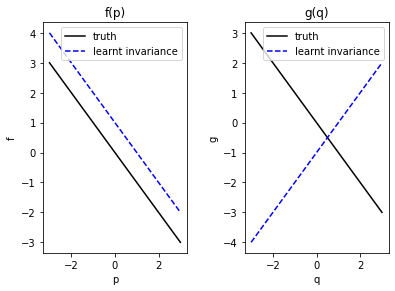

In [30]:

from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -model.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, -(x), color="black", label='truth')
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#plt.savefig("figures/shm_learnt.pdf")



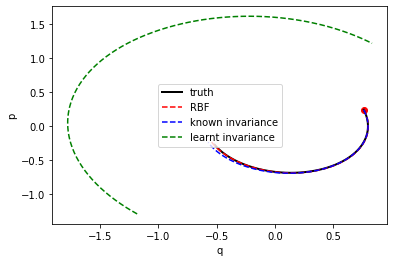

In [14]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/shm_predicted.pdf")

Text(0, 0.5, 'E')

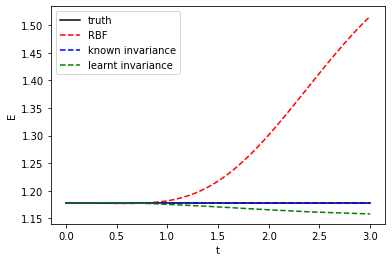

In [20]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_energy.pdf")

In [ ]:

import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future

In [ ]:

lmls = np.zeros(5)
future = np.zeros((3,5))
dofs = np.zeros(5)
energies = np.zeros((3,5))
moi = get_GPR_model(get_MOI(), mean, data, 500)
lmls[0]=(moi.log_marginal_likelihood().numpy())
dofs[0] = degree_of_freedom(moi.kernel, np.radians(150),40,moi.likelihood.variance.numpy())
invar_density=20
for i in range(3):
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))
    test_starting = (test_starting_position, test_starting_velocity)
    for j, jitter in enumerate([7e-6, 1e-5, 5e-5, 9e-5]):
        print(invar_density)
        try:
            kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
            m = get_GPR_model(kernel, mean, data, 500)
        except tf.errors.InvalidArgumentError:
            print("jitter too small")
            break 
        lmls[j+1]=(m.log_marginal_likelihood().numpy())
        dofs[j+1] = degree_of_freedom(m.kernel, np.radians(150),40,m.likelihood.variance.numpy())
        print(m.log_marginal_likelihood().numpy())

    #        print(test_starting_position)
    #        print(test_starting_velocity)

        evaluate_moi = evaluate_model_future(moi, test_starting, dynamics, time_setting, energy)

        future[i,0]=(evaluate_moi[0])
        energies[i,0]=abs((evaluate_moi[6][-1]-evaluate_moi[6][0])/evaluate_moi[6][0])

        evaluate_invariance = evaluate_model_future(m, test_starting, dynamics, time_setting, energy)
        print(format(evaluate_invariance[0],".4f"))
        future[i,j+1] = (evaluate_invariance[0])
        energies[i,j+1]=abs((evaluate_invariance[6][-1]-evaluate_invariance[6][0])/evaluate_invariance[6][0])



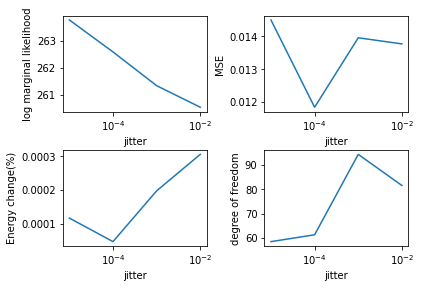

In [60]:

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
invs =[1e-5, 1e-4, 1e-3, 1e-2]
axs[0][0].plot(invs, lmls[1:5])
#axs[0][0].plot(invs, np.ones(4)*lml_inv[0],'--', color="black")
axs[0][0].set_ylabel("log marginal likelihood")
axs[0][0].set_xlabel("jitter")
axs[0][0].set_xscale('log')
axs[0][1].plot(invs, np.mean(future[:,1:5],0))
#axs[0][1].plot(invs, np.ones(4)*np.mean(future_inv[:,0],0),'--', color="black")
axs[0][1].set_ylabel("MSE")
axs[0][1].set_xlabel("jitter")
axs[0][1].set_xscale('log')
axs[1][0].plot(invs, abs(np.mean(energies[:,1:5],0)))
#axs[1][0].plot(invs, np.ones(4)*grid_inv[0],'--', color="black")
axs[1][0].set_xlabel("jitter")
axs[1][0].set_ylabel("Energy change(%)")
axs[1][0].set_xscale('log')
axs[1][1].plot(invs, dofs[1:5])
#axs[1][1].plot(invs, np.ones(4)*dofs[0],'--', color="black")
axs[1][1].set_ylabel("degree of freedom")
axs[1][1].set_xlabel("jitter")
axs[1][1].set_xscale('log')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/vary_jitter.pdf")

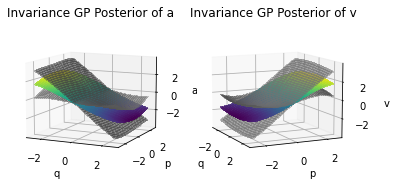

In [15]:

test_range = np.radians(150)
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = m.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Posterior of v")
#plt.savefig("figures/posterior_shm_invariance.pdf")

In [ ]:

test_range = 5
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred = tf.zeros((test_points.shape[0], 1), dtype=tf.float64)
#var = tf.linalg.diag_part(get_pendulum_invariance(np.radians(150), invar_density, jitter)(test_points))
#var = tf.linalg.diag_part(get_SHM_invariance(5, invar_density, jitter)(test_points))
var = tf.linalg.diag_part(get_MOI()(test_points))
X, Y = data
pred_a = pred
var_a = var[:int(var.shape[0]/2)]
pred_v = pred
var_v = var[int(var.shape[0]/2):]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("RBF GP Prior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("RBF GP Prior of v")
#plt.savefig("figures/prior_shm_rbf.pdf")